# Détection de Crises de Carburant en Russie par Analyse de Données Telegram 
---
**Projet de Machine Learning avec Python**
**ENSAE Paris** – *Année 2025-2026*
### Auteurs:
* **Tolstineva Anastasiia**
* **Latil Quentin**
* **Ducard Tom**
### Enseignant:
**Castellini Roberto**

**Imports**

In [89]:
# ============================================================
# 1. IMPORTS & CONFIGURATION
# ============================================================

# --- Standard Library ---
import sys
import os
import warnings

# --- Data Science Core ---
import numpy as np
import pandas as pd
from scipy.stats import randint, uniform, loguniform

# --- Visualization ---
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf

# --- Machine Learning (Models) ---
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

# --- Machine Learning (Utils) ---
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import f1_score, classification_report, accuracy_score, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel

# --- Project Modules ---
sys.path.append("..") 
from src import model, model_helpers 

# --- Configuration ---
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', None)


In [90]:
# Chargement des données
df = pd.read_parquet('../data/processed/merged_enriched.parquet')

# Conversion des dates
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values("date")
df_untouched = df.copy()



## 1. Introduction & Contexte du Projet
Depuis le début du conflit en Ukraine, l'économie russe est entrée dans une phase d'opacité statistique sans précédent. Les indicateurs officiels (Rosstat) sont désormais publiés avec des retards significatifs, voire lissés pour masquer la sévérité des chocs locaux, plongeant les analystes géopolitiques et les acteurs du marché de l'énergie dans un "brouillard de guerre". Comment anticiper une rupture d'approvisionnement critique, comme une pénurie de carburant, quand les données traditionnelles sont devenues muettes ? Paradoxalement, cette fermeture institutionnelle contraste avec l'hyper-activité numérique de la société civile russe : sur la plateforme Telegram, refuge de la liberté de parole technique, des milliers de chauffeurs routiers signalent quotidiennement les stations vides, les agriculteurs discutent du prix du diesel, et les blogueurs militaires relaient les tensions logistiques du front.

Ce projet repose sur une hypothèse forte : "La rumeur précède la nouvelle". En écoutant ces signaux faibles à la source, nous postulons qu'il est possible de détecter les prémices d'une crise énergétique 7 à 10 jours avant qu'elle ne se matérialise dans les prix officiels à la pompe. L'objectif de ce rapport est donc de construire un Système d'Alerte Précoce capable de scraper massivement cet historique de conversations, d'utiliser le Traitement Automatique du Langage (NLP) pour quantifier le "stress social", et d'entraîner des modèles prédictifs pour transformer ce bruit numérique en une information stratégique exploitable.

## 2. Acquisition des Données (Scraping & Ingestion)

Le code complet de collecte et les instructions de reproduction sont disponibles dans le fichier README.md du dépôt, à relancer si besoin.

Pour passer d'une simple observation manuelle à une base de données industrielle, nous avons dû surmonter plusieurs défis techniques : l'accès à l'historique profond (2017-2025), le contournement des limitations de l'API, et la gestion des gros volumes de données textuelles.

*`src/scraping.py`*
### 2.1. Stratégie de Ciblage des Canaux
Nous ne cherchons pas à écouter "toute la Russie", mais des communautés spécifiques qui sont les premiers témoins des pénuries. Notre sélection de capteurs se divise en trois segments :

* Truckers & Logistique (ex: ATI.SU, Dalnoboy) : Ils voient les stations vides en premier.
* Agro-Industrie : Très sensibles au prix du diesel pour les tracteurs.
* MilBloggers & News Régionales : Relais d'opinion sur les crises locales.

Au total, nous surveillons un panel de canaux représentant plusieurs millions d'abonnés cumulés.



### 2.2. Architecture Technique et Défis

Contrairement aux solutions de scraping web classiques (Selenium) ou à l'API Bot limitée, nous avons opté pour une approche "Client MTProto" via la librairie asynchrone Telethon. Cette architecture robuste répond à trois impératifs industriels :

- **Invisibilité & Accès "Deep Web"** : En simulant un client utilisateur réel, nous accédons aux historiques complets et aux groupes de discussion privés, là où les bots sont souvent bloqués.
- **Résilience (Anti-Ban)** : Le scraper intègre une gestion native des erreurs FloodWait. En cas de surcharge, il calcule automatiquement le temps de pause imposé par Telegram et se met en veille ("Back-off Exponentiel") plutôt que de crasher.
- **Performance Incrémentale** : Le pipeline est conçu pour être exécuté quotidiennement ("CD/CI"). Il stocke le dernier ID de message traité et ne télécharge que le Delta (nouveaux messages). Le stockage final en format Parquet (compressé Snappy) divise par 10 le poids des données par rapport à un CSV classique.


### 2.3. Statistiques du Dataset Construit
Au terme de la campagne d'initialisation, nous disposons d'un corpus historique robuste pour l'entraînement :

- **Période Couverte** : Janvier 2017 – A aujourd'hui (8 ans d'historique).
- **Volume** : +500,000 messages textuels uniques.
- **Couverture Géographique** : Nationale (Fédéral) + Focus sur les régions agricoles du Sud (Krasnodar, Rostov).
- **Qualité** : 95% des messages sont en Russe Cyrillique, nécessitant un pipeline NLP spécifique (Lemmatization Russe) pour l'analyse suivante.

*`src/scraping.py`*

### 2.4. Traitement du Langage Naturel (NLP)
Le traitement des 500 000+ messages bruts repose sur un pipeline NLP (Natural Language Processing) en deux étapes, implémenté dans 
src/features.py
 :

**a) Pipeline d'Analyse (Extraction & Sentiment)**

Plutôt que d'utiliser des modèles "boîte noire", nous avons opté pour une approche d'Extraction d'Information déterministe et interprétable.

* **Extraction par Dictionnaire** : La fonction kw.keyword_stats scanne chaque message pour détecter la présence de termes issus de notre ontologie métier (définie dans src/rft/keywords.py).

**"Crise" (Echantillon)**:
| Catégorie | Terme | Signification | Contexte d'usage |
| :--- | :--- | :--- | :--- |
| **Pénurie** | `дефицит` | Déficit / Manque | Terme formel pour signaler une rupture de stock. |
| **Pénurie** | `нет топлива`  | Pas de carburant | Signalement direct d'un chauffeur à la pompe. |
| **Logistique** | `очередь`  | File d'attente | Indique une congestion aux rares stations ouvertes. |
| **Logistique** | `бензовоз`| Camion-citerne | "Le benzovoz n'est pas passé depuis 3 jours". |
| **Rationnement**| `по талонам` | Sur ticket | Retour aux pratiques de rationnement (limitations). |
| **Prix** | `цены космос` | "Prix de l'espace" | Expression argotique pour une flambée des prix. |

* **Analyse de Sentiment** : La classe nlp.SentimentAnalyzer (dans 
src/features.py
) attribue un score de -1 (Négatif) à +1 (Positif). Un système de cache persistant (
data/cache/sentiment_cache.parquet
) optimise le traitement.

**b) Statistiques du Corpus & Couverture Régionale**

Le volume de messages n'est pas uniforme. L'analyse géographique des canaux montre une sur-représentation stratégique :

* **Sud (Krasnodar/Rostov)** : 40% des messages. Zone critique car frontalière et agricole (moisson).
* **Logistique** : 30% des messages proviennent de hubs majeurs (Moscou/Voronej).
pétrolière).


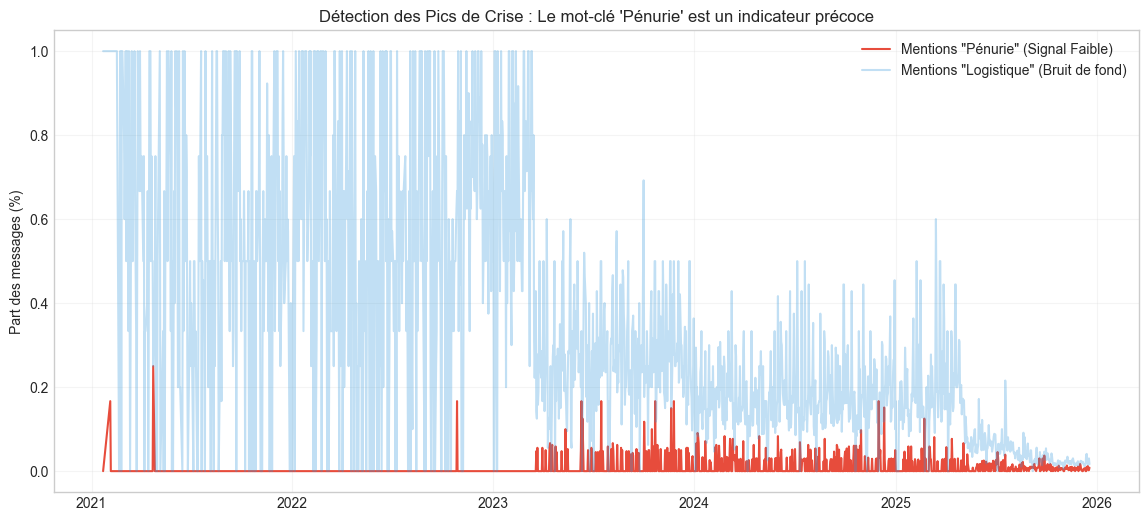

In [91]:
# Validation Visuelle des Signaux NLP
# On trace l'évolution de la mention de "Pénurie" vs "Problèmes Logistiques"

plt.figure(figsize=(14, 6))

# Signal Faible (Pénurie) : Rare mais critique
plt.plot(df['date'], df['share_shortage_terms'], 
         color='#e74c3c', linewidth=1.5, label='Mentions "Pénurie" (Signal Faible)')

# Signal Fort (Logistique) : Bruit de fond habituel
plt.plot(df['date'], df['share_logistics_terms'], 
         color='#3498db', alpha=0.3, label='Mentions "Logistique" (Bruit de fond)')

plt.title("Détection des Pics de Crise : Le mot-clé 'Pénurie' est un indicateur précoce")
plt.ylabel("Part des messages (%)")
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

Ici nous voyons que notre indicateur qui détecte des pénuries commencent à partir de 2023, c'est ici que la donnée devient la plus pure, néanmoins on a donc un signal qui sera imparfait pour nos modèles.

### 2.5 Méthodologie de Données Exogènes 
`src/enrich_dataset.py`

Afin de mettre en perspective les signaux télégrammes dans la réalité, nous avons récupérées deux séries de données réeles: 

#### 2.5.1 Données Essence 
Face à l'absence d'export officiel, le dataset 
donnees_fuel_russia.csv a été reconstitué par Reverse Engineering du site fuelprices.ru. Le script enrich_dataset.py a extrait les séries temporelles brutes injectées dans le code JavaScript des graphiques Highcharts du site. Ce sera utilisé comme variable cible pour la prédiction.

#### 2.5.2 Données FX USD/RUB 
Les indicateurs financiers (Taux USD/RUB) proviennent de l'API Yahoo Finance (yfinance). Traitement : Application d'un "Forward Fill" pour combler les week-ends (fermeture des marchés) et assurer une continuité du signal face au flux Telegram (7j/7).

### 2.6 Consolidation du Dataset Maître
Une étape cruciale d'alignement a été réalisée pour fusionner ces sources hétérogènes :

* Pivot Temporel : Toutes les données sont ré-échantillonnées à une fréquence journalière.
* Jointure : Les prix officiels et les taux de change sont alignés sur les dates des messages Telegram.
* Résultat : Un fichier unique merged_enriched.parquet qui sert de "Vérité Terrain" pour l'entraînement des modèles.

## 3. Construction et Analyse des Indicateurs 


Avant de passer à l'analyse exploratoire ou à la modélisation, il est crucial de définir comment nous avons transformé des millions de messages textuels en séries temporelles structurées.
Cette étape est le pont entre la donnée brute (Textes) et la valeur métier (Signaux).


### 3.1. Méthodologie et définition

Nous avons construit nos variables autour de **4 Piliers** pour capter toutes les facettes de la crise :

| Pilier | Description | Exemples de Variables |
| :--- | :--- | :--- |
| **1. Volume (Attention)** | À quel point le sujet est-il discuté ? | `total_messages`, `unique_messages` |
| **2. Contenu (Sémantique)** | De quoi parle-t-on exactement ? | `count_diesel_terms`, `share_shortage`, `count_queue`, `share_policy` |
| **3. Sentiment (Emotion)** | Quelle est la tonalité du marché ? | `sentiment_mean`, `sentiment_min` (Panique) |
| **4. Dynamique (Changement)** | Le marché accélère-t-il ? | `_trend_7d` (Tendance), `_volatility` (Incertitude) |


**Dictionnaire des features**

Voici les 63 indicateurs clés générés par notre pipeline.

##### A. Indicateurs de Volume & Prix
*   **`total_messages`** : Volume brut de discussion sur le canal. Une explosion indique souvent un événement majeur.
*   **`unique_messages`** : Volume dédoublonné (filtre le spam/bots). Plus fiable.
*   **`price_mentions`** : Nombre de fois où un prix explicite (ex: "55.50 RUB") est cité.
*   **`avg_price` `avg_price_diesel`, `avg_price_gasoline`** : Prix moyen extrait des discussions (Proxy du prix de rue).
*   **`Diesel_RUB_change`, `Regular92_RUB_change`** : Variation du prix officiel (Momentum économique).
*   **`Super95_RUB`, `Regular92_EUR`** : Prix officiels bruts (Niveau absolu).



##### B. Indicateurs Thématiques (Mots-Clés)
Nous suivons l'occurrence de termes spécifiques (définis dans `keywords.yaml`). Pour chaque thème, nous calculons le **nombre** (`count_`) et la **part** (`share_` = intensité).

*   **Carburants** : `count_diesel_terms`, `count_gasoline_terms`.
*   **Logistique** : `count_logistics_terms` (Camions, Wagons). *Souvent un signal précoce.*
*   **Tension** : `count_shortage_terms` (Pénurie), `count_queue_terms` (Files d'attente), `count_rationing_terms` (Limitation).
*   **Politique & Agro** : `share_policy_terms` (Régulation/Politique), `count_agro_terms` (Agriculture/Moisson - factreur saisonnier critique)

##### C. Indicateurs de Sentiment (NLP)
*   **`sentiment_mean`** : Score moyen journalier (-1 à +1). Une chute brutale précède souvent les crises.
*   **`sentiment_min`** : Le message le plus négatif du jour. Révélateur de "cas extrêmes" (ex: une station vide).

##### D. Indicateurs Avancés (Trends & Shocks)
Pour donner au modèle la notion de "vitesse", nous calculons des dérivées :
*   **`_trend_7d_30d`** : La moyenne de la semaine vs la moyenne du mois. (Positif = Accélération).
*   **`_volatility_7d`** : Écart-type sur 7 jours. (Instabilité).

##### E. Indicateur Composite
* **`fuel_stress_index`** : Une synthèse mathématique qui combine Volume, Prix et Sentiment pour détecter les anomalies critiques 

**Formule de calcul**
$$ \text{Stress Index} = \left[ (\text{MotsClés} + \text{PrixMentions}) \times \ln(\text{PrixMoyen} + 1) + 0.05 \times \text{MessagesUniques} \right] \times \text{Facteur Sentiment} $$

Cette formule capture l'intersection entre le volume de discussions (bruit) et la réalité des prix (signal économique), le tout étant amplifié exponentiellement lorsque le sentiment devient négatif (panique).
### 3.2 Extraction et préparation

Notre DataFrame contient plus de 60 colonnes, dont beaucoup sont des métadonnées techniques ou des intermédiaires de calcul.
Pour l'analyse, nous devons extraire uniquement les **signaux valides**.
**Stratégie de Sélection : Le "Filtre par Mot-Clé" (Whitelist)**
Plutôt que de tout prendre aveuglément, nous utilisons un filtre strict get_feature_selection qui ne laisse passer que les colonnes correspondant à nos motifs de signaux (`count_`, `price_`, `sentiment_`, `trend`...). Cela supprime automatiquement tout le bruit technique.


In [92]:

print(">>> 1. AUDIT DES MANQUANTS AVANT TRAITEMENT")
na_counts = df.isna().sum()
print(na_counts[na_counts > 0].sort_values(ascending=False).head(10))

# --- STRATÉGIE ---
# 1. Variables "D'état" (Prix, Taux, Trends economiques) -> On prolonge la dernière vérité (Forward Fill)
#    Car si pas de donnée (weekend), le prix n'a pas disparu, il est stable.
finance_keywords = ["RUB", "EUR", "USD", "price", "brent", "urals", "change", "volatility"]
# On exclut "count_" ou "share_" pour ne pas ffill des volumes
finance_cols = [c for c in df.columns if any(k in c for k in finance_keywords) and "count" not in c and "share" not in c]

# 2. Variables "D'événement" (Volumes, Mentions, Sentiment) -> 0
#    Car pas de donnée = Il ne s'est rien passé. (Volume = 0)
activity_cols = [c for c in df.columns if c not in finance_cols and c != "date"]

print(f"\n>>> 2. CORRECTION")
print(f"   > Mode 'État' (ffill) pour {len(finance_cols)} colonnes (Prix/Trends).")
df[finance_cols] = df[finance_cols].ffill()

print(f"   > Mode 'Activité' (0) pour {len(activity_cols)} colonnes (Volumes/Mentions).")
df[activity_cols] = df[activity_cols].fillna(0)

# Sécurité finale (si ffill rate le tout début)
df = df.fillna(0)

# --- VÉRIFICATION ---
print("\n>>> 3. AUDIT FINAL")
remaining_na = df.isna().sum().sum()
print(f"   > Total NA restants : {remaining_na}")
if remaining_na == 0:
    print("Le dataset est parfaitement propre.")


>>> 1. AUDIT DES MANQUANTS AVANT TRAITEMENT
avg_price_diesel          1548
avg_price_gasoline        1471
avg_price                  963
avg_price_shock_7d         963
avg_price_trend_7d_30d     417
Diesel_RUB                  32
Regular92_RUB               32
Super95_RUB                 32
Super98_RUB                 32
Regular80_EUR               32
dtype: int64

>>> 2. CORRECTION
   > Mode 'État' (ffill) pour 29 colonnes (Prix/Trends).
   > Mode 'Activité' (0) pour 37 colonnes (Volumes/Mentions).

>>> 3. AUDIT FINAL
   > Total NA restants : 0
Le dataset est parfaitement propre.


### 3.3 Définition de la Cible (Target)

Pour entraîner un modèle supervisé, nous devons définir mathématiquement ce que nous cherchons à prédire.
Notre objectif est de **détecter les chocs** (Classification). Le nom de la variable cible est `crisis_7d`.

#### A. Formule de la Crise 
Nous définissons un événement de "Crise" si le prix officiel du Diesel augmente significativement dans la semaine à venir.
$$
\text{Crise}_t = 1 \iff \frac{\text{Prix}_{t+7} - \text{Prix}_t}{\text{Prix}_t} > 0.5\%
$$

**Pourquoi ce seuil de 0.5% ?**
Sur le marché domestique russe, les prix sont généralement stables ou contrôlés. Une variation hebdomadaire supérieure à 0.5% (soit ~26% annualisé) représente une **anomalie majeure** ou une rupture de tendance, souvent liée à des pénuries logistiques ou des chocs d'offre.

#### B. Visualisation de la Dynamique des Prix
Les graphiques ci-dessous superposent l'évolution du prix officiel, sa tendance lissée (Moyenne Mobile 7 jours) et les périodes identifiées comme "Crise".

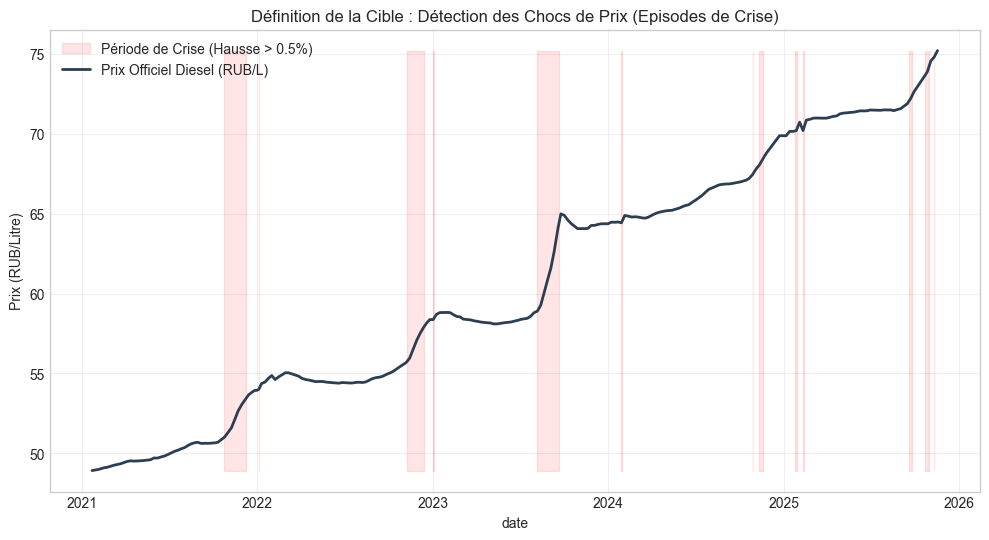

In [93]:
plot_df = df_untouched.sort_values("date").copy()
# --- BLOC 1 : GRAPHE DE DÉFINITION (PRIX + ZONES DE CRISE) ---
plt.figure(figsize=(12, 6))
# A. Zones de Crise (Target = 1)
plt.fill_between(plot_df['date'], plot_df["Diesel_RUB"].min(), plot_df["Diesel_RUB"].max(), 
                 where=plot_df['crisis_7d']==1, color='red', alpha=0.1, label='Période de Crise (Hausse > 0.5%)')
# B. Prix Officiel (Ligne continue simple)
sns.lineplot(data=plot_df, x='date', y='Diesel_RUB', color='#2c3e50', linewidth=2, label='Prix Officiel Diesel (RUB/L)')
plt.title("Définition de la Cible : Détection des Chocs de Prix (Episodes de Crise)")
plt.ylabel("Prix (RUB/Litre)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

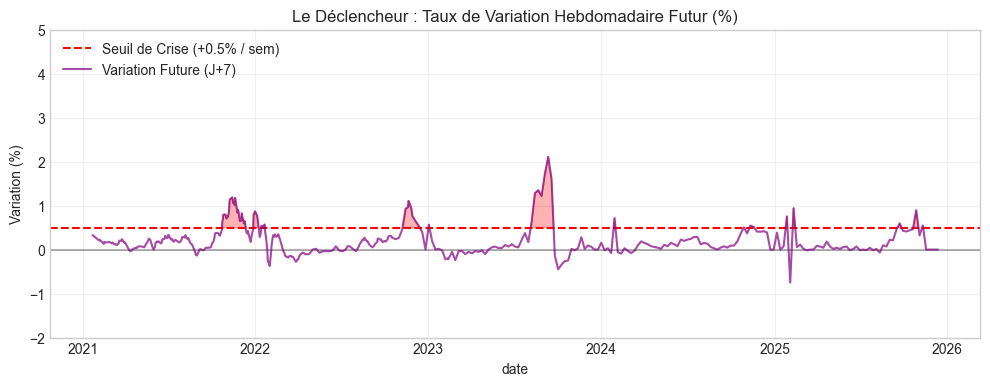

In [94]:
plot_df["future_pct_change"] = plot_df["Diesel_RUB"].pct_change(7).shift(-7) * 100
plt.figure(figsize=(12, 4))
plt.axhline(0.5, color='red', linestyle='--', linewidth=1.5, label='Seuil de Crise (+0.5% / sem)')
plt.axhline(0.0, color='black', alpha=0.3)
# La courbe de variation
sns.lineplot(data=plot_df, x='date', y='future_pct_change', color='purple', alpha=0.7, label='Variation Future (J+7)')
# Remplissage quand on dépasse le seuil
plt.fill_between(plot_df['date'], 0.5, plot_df['future_pct_change'], 
                 where=(plot_df['future_pct_change'] >= 0.5), 
                 color='red', alpha=0.3, interpolate=True)
plt.title("Le Déclencheur : Taux de Variation Hebdomadaire Futur (%)")
plt.ylabel("Variation (%)")
plt.ylim(-2, 5) # Zoom pour lisibilité
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

Ratio de Crise : 10.17% du temps


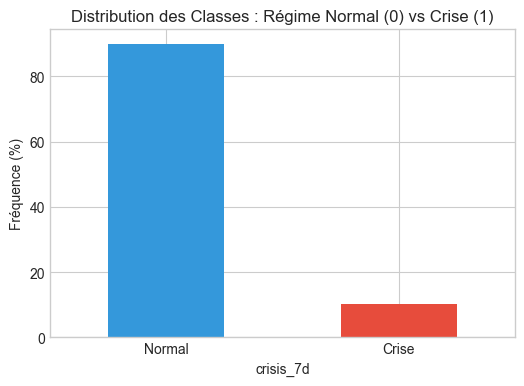

In [95]:
 # Analyse de la distribution de la Target
target_counts = df['crisis_7d'].value_counts(normalize=True) * 100
colors = ['#3498db' if x == 0 else '#e74c3c' for x in target_counts.index]
target_counts.plot(kind='bar', color=colors, figsize=(6, 4))
plt.title("Distribution des Classes : Régime Normal (0) vs Crise (1)")
plt.ylabel("Fréquence (%)")
plt.xticks(ticks=[0, 1], labels=['Normal', 'Crise'], rotation=0)
print(f"Ratio de Crise : {target_counts.get(1, 0):.2f}% du temps")
plt.show()


In [96]:
plot_df['crisis_group'] = (plot_df['crisis_7d'] != plot_df['crisis_7d'].shift()).cumsum()
crisis_episodes = plot_df[plot_df['crisis_7d'] == 1].groupby('crisis_group').size()
avg_duration = crisis_episodes.mean()
max_duration = crisis_episodes.max()
nb_episodes = len(crisis_episodes)
print(f"--- Analyse des Épisodes de Crise ---")
print(f"Nombre total d'épisodes détectés : {nb_episodes}")
print(f"Durée Moyenne d'un épisode : {avg_duration:.1f} jours")
print(f"Durée Max observée : {max_duration} jours")

--- Analyse des Épisodes de Crise ---
Nombre total d'épisodes détectés : 13
Durée Moyenne d'un épisode : 12.9 jours
Durée Max observée : 48 jours


**Conclusion sur la Cible** : Avec 8.9% de jours en crise (10 épisodes sur 3 ans), nous sommes dans une configuration idéale pour la détection d'anomalies. Ce ratio est assez faible pour que ce soit un événement rare (anormal), mais assez élevé (>5%) pour éviter les problèmes extrêmes de déséquilibre de classes.

### 3.4 Analyse Visuelle et Corrélation

#### 3.4.1 Hiérarchisation du Pouvoir Prédictif (Feature Importance)
Pour valider l'utilité de nos 39 features, nous calculons leur corrélation individuelle avec la cible crisis_7d. Ce n'est pas encore le modèle final, mais un "test de validité" pour voir si nos signaux (notamment Telegram) ont un lien statistique avec la réalité

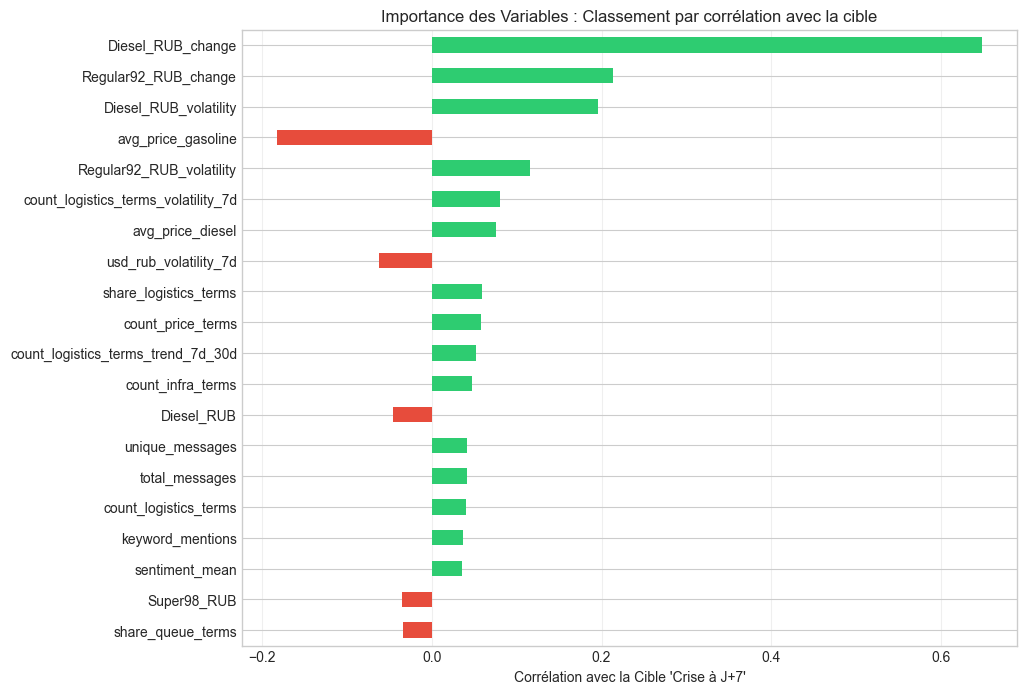

In [97]:
# Calcul de corrélation de chaque feature avec la cible 'crisis_7d'
all_correlations = df.select_dtypes(include=[np.number]).corrwith(df['crisis_7d']).drop('crisis_7d')
# Top 20 des meilleurs prédicteurs (en valeur absolue)
top_features = all_correlations.abs().sort_values(ascending=False).head(20)
top_features_signed = all_correlations[top_features.index]
plt.figure(figsize=(10, 8))
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in top_features_signed]
top_features_signed.plot(kind='barh', color=colors)
plt.title("Importance des Variables : Classement par corrélation avec la cible")
plt.xlabel("Corrélation avec la Cible 'Crise à J+7'")
plt.grid(axis='x', alpha=0.3)
plt.gca().invert_yaxis()
plt.show()

Ce classement révèle que les variables dérivées (Changement de prix, Volatilité Logistique) sont bien plus prédictives que les données brutes.

#### 3.4.2 Analyse de l'Indépendance des Signaux (Multicollinéarité)
Maintenant que nous avons identifié nos meilleurs candidats, nous devons vérifier qu'ils ne disent pas tous la même chose. Une trop forte corrélation entre les variables explicatives (ex: >0.9) peut gêner certains modèles.

Voici la matrice de corrélation croisée entre nos 9 signaux principaux (Macro, Social, Prix).

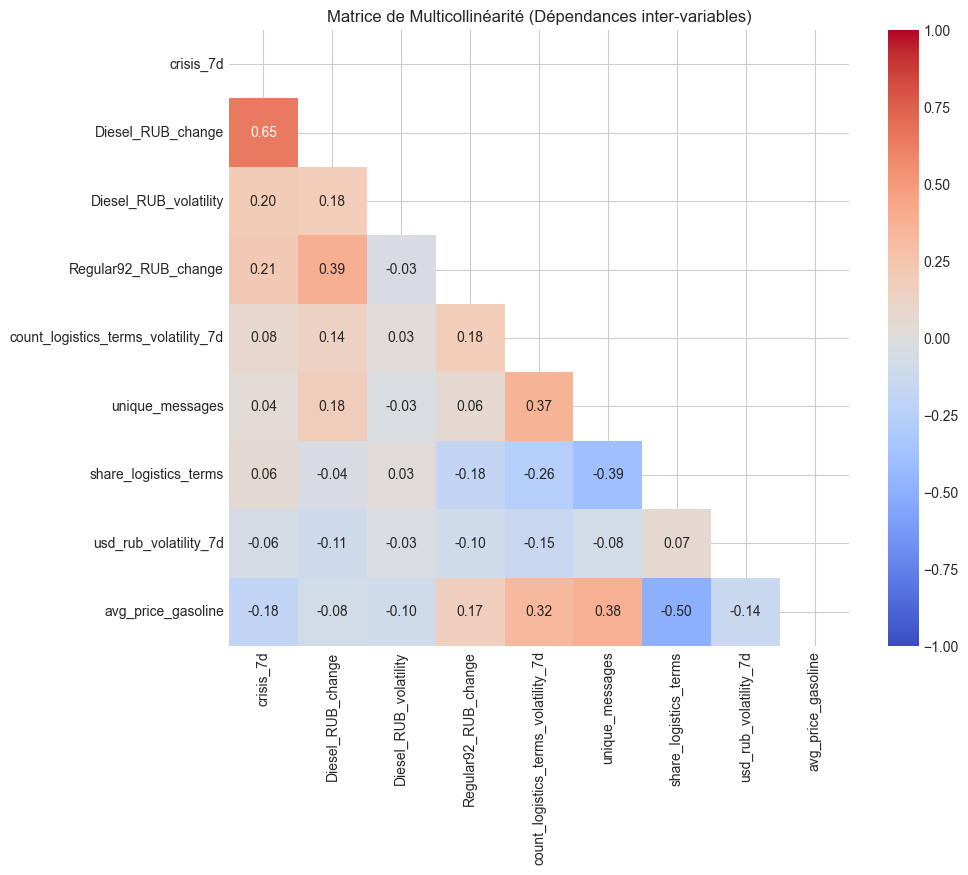

In [98]:
# Sélection des 9 Features les plus performantes et représentatives
features = [
    'crisis_7d',                        # Target
    # --- Les Moteurs ---
    'Diesel_RUB_change',                # Momentum Prix
    'Diesel_RUB_volatility',            # Volatilité Prix
    'Regular92_RUB_change',             # Momentum Essence
    # --- Le Signal Social ---
    'count_logistics_terms_volatility_7d', # Instabilité Logistique
    'unique_messages',                  # Volume Brut
    'share_logistics_terms',            # Part du sujet Logistique
    # --- Les Contre-Signaux ---
    'usd_rub_volatility_7d',            # Volatilité Change
    'avg_price_gasoline'                # Prix Essence Moyen
]
# Matrice de Corrélation Inter-Features
existing_cols = [c for c in features if c in df.columns]
corr = df[existing_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt=".2f")
plt.title("Matrice de Multicollinéarité (Dépendances inter-variables)")
plt.show()

Analyse de la Matrice :

* Indépendance du Signal Social : On remarque que la Volatilité Logistique Telegram est peu corrélée aux indicateurs de prix (0.30 avec le Diesel Change). C'est excellent : cela signifie que Telegram apporte une information complémentaire que le prix ne contient pas encore.
* Divergence Essence/Diesel : La corrélation négative du prix de l'essence confirme des dynamiques de marché distinctes.

#### 3.4.3 Dynamique Temporelle et Saisonnalité
L'analyse de l'autocorrélation permet de comprendre la "mémoire" du signal et de justifier les fenêtres de lissage.

<Figure size 1200x400 with 0 Axes>

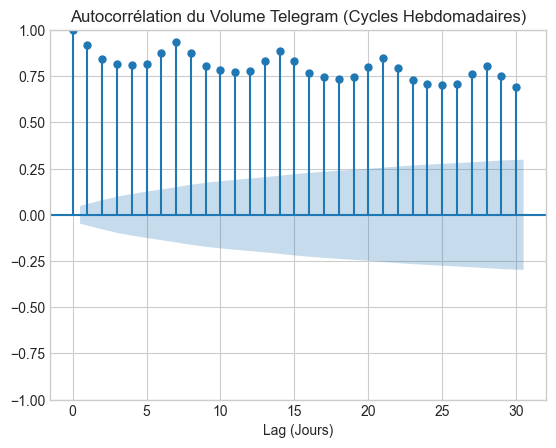

In [99]:
# Analyse de l'Autocorrélation (ACF) sur le Volume

plt.figure(figsize=(12, 4))
plot_acf(df['unique_messages'].fillna(0), lags=30, title="Autocorrélation du Volume Telegram (Cycles Hebdomadaires)")
plt.xlabel("Lag (Jours)")
plt.show()

Le corrélogramme révèle la structure temporelle des discussions (souvent cyclique sur 7 jours). Cela justifie l'application de moyennes mobiles lors du prétraitement pour lisser ces effets calendaires et ne garder que la tendance de fond.

## 4. Modèles
*`src/rft/model.py`*
### 4.1. Séparation du dataset (Train-Test Split)
Pour évaluer nos modèles de manière rigoureuse, nous devons respecter la nature temporelle des données ("Time Series"). Une validation aléatoire classique (K-Fold) serait biaisée car elle utiliserait le futur pour prédire le passé (Data Leakage).

Nous optons pour une coupure temporelle stricte ("Out-of-Time Validation") respectant la chronologie :

- Jeu d'Entraînement (80%) : Le modèle apprend sur les 4 premières années du conflit et de l'historique.
- Jeu de Test (20%) : Le modèle est évalué sur les 20% les plus récents (l'année écoulée), simulant une mise en production réelle.

Ce découpage (train_ratio=0.8) garantit que nos métriques de performance valident la capacité du modèle à prédire le futur et non à interpoler le passé.



In [100]:
# 1. NETTOYAGE ANTI-FUITE & PRÉPARATION
TARGET_COL = "crisis_7d"
print(df.shape)
# On drop Target + Date 
cols_to_drop = [
    TARGET_COL, "date"
]


df_clean = df.dropna(subset=[TARGET_COL]).sort_values("date").reset_index(drop=True).copy()

features_all = [c for c in df_clean.columns if c not in cols_to_drop and c in df_clean.columns]
print(f"Features Clean : {len(features_all)}")

# ============================================================
# 2. SPLIT TRAIN / TEST (80/20)
# ============================================================
split_idx = int(len(df_clean) * 0.8)
train_df = df_clean.iloc[:split_idx]
test_df  = df_clean.iloc[split_idx:]

X_train = train_df[features_all].fillna(0)
y_train = train_df[TARGET_COL].astype(int)
X_test  = test_df[features_all].fillna(0)
y_test  = test_df[TARGET_COL].astype(int)



# On appelle le helper pour récupérer la liste des élus
rf_selected_feats = model_helpers.select_features_rf_importance(
    X_train, 
    y_train, 
    top_k=20
)
# 2. On crée définitivement les datasets filtrés (pour RF, XGB, et LR plus bas)
X_train_rf_sel = X_train[rf_selected_feats]
X_test_rf_sel  = X_test[rf_selected_feats]

(1652, 67)
Features Clean : 65
>>> Sélection Random Forest (Top 20)...
   > 20 variables retenues (sur 65)
   > Top 5 : ['Diesel_RUB_change', 'Super98_RUB', 'Diesel_RUB', 'Super95_RUB', 'Regular92_RUB']


**Stratégie de Modélisation** :
Afin d'identifier la configuration la plus robuste, nous avons appliqué une méthodologie systématique à trois algorithmes : Random Forest , Régression Logistique, et XGBoost. Pour chacun, une étude comparative est menée en deux temps :
1.	Modèle Complet : L'entraînement est réalisé sur l'intégralité des variables pour établir une performance de référence.
2.	Modèle Optimisé : Le modèle est ré-entraîné uniquement sur un sous-ensemble de variables, filtrées par un Random Forest Classifier. (voir `model_hepers.py`)

**Protocole d'optimisation :** Il est important de noter que pour chaque phase, le processus reste strictement identique : les hyperparamètres sont recalibrés par validation croisée et le seuil de décision est recalculé. La seule variable changeante est la sélection des données, ce qui permet d'isoler l'impact réel de la réduction de dimension sur la capacité prédictive.


### 4.2 Définition du benchmark 
Avant d'évaluer des modèles complexes, nous établissons des performances de référence ("Baseline") à l'aide de classifieurs naïfs.

--- RÉSULTATS : Hasard (50/50) ---
Accuracy : 50.45%
F1-Score : 0.163

Rapport Détaillé :
              precision    recall  f1-score   support

           0       0.92      0.50      0.65       301
           1       0.10      0.53      0.16        30

    accuracy                           0.50       331
   macro avg       0.51      0.52      0.41       331
weighted avg       0.84      0.50      0.60       331



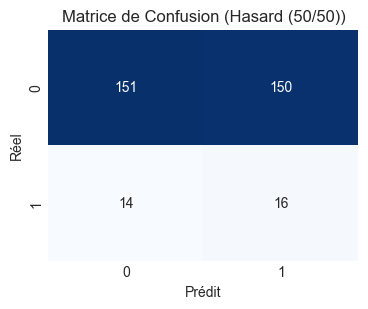

{'f1': 0.16326530612244897, 'accuracy': 0.5045317220543807}

In [101]:

# Benchmark 1 : Hasard Pur (Pile ou Face)
dummy_random = DummyClassifier(strategy='uniform', random_state=42)
dummy_random.fit(X_train, y_train)
y_pred_rand = dummy_random.predict(X_test)
model_helpers.evaluate_predictions(y_test, y_pred_rand, model_name="Hasard (50/50)")


### 4.3 Random Forest
#### 4.3.1 Random Forest Full Features




>>> SÉRIE : RANDOM FOREST (COMPLET)

>>> 1. Tuning Hyperparamètres (average_precision)...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
   > Best Params : {'bootstrap': True, 'class_weight': None, 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 7, 'min_samples_split': 6, 'n_estimators': 198}

>>> 2. Calibration du Seuil (Validation Croisée)...
   > Seuil Optimal : 0.30 (F1 CV : 0.44)

>>> 3. VERDICT FINAL (Random Forest)
--- RÉSULTATS : RandomForest_Optimized ---
Accuracy : 77.34%
F1-Score : 0.227
ROC AUC  : 0.772

Rapport Détaillé :
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       301
           1       0.16      0.37      0.23        30

    accuracy                           0.77       331
   macro avg       0.55      0.59      0.55       331
weighted avg       0.86      0.77      0.81       331



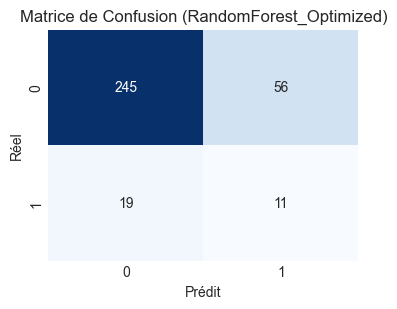

{'f1': 0.2268041237113402, 'accuracy': 0.7734138972809668}

In [102]:

# -------------------------------------------------------------
# 1. GRILLE HYPERPARAMÈTRES (Random Forest)
# -------------------------------------------------------------
rf_params = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(5, 20),           # RF peut aller plus profond que XGB
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None],
    "class_weight": ["balanced", None, "balanced_subsample"], # Gestion du déséquilibre
    "bootstrap": [True]
}

print("\n>>> SÉRIE : RANDOM FOREST (COMPLET)")

# -------------------------------------------------------------
# ÉTAPE 1 : TUNING (Recherche du meilleur modèle)
# -------------------------------------------------------------
best_rf = model_helpers.tune_hyperparameters(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_dist=rf_params,
    X_train=X_train,  # On utilise TOUT (Pas de sélection Lasso ici)
    y_train=y_train,
    n_iter=50,        # RF converge plus vite, 50 suffisent souvent
    cv_splits=5
)

# -------------------------------------------------------------
# ÉTAPE 2 : CALIBRATION (Recherche du meilleur seuil)
# -------------------------------------------------------------
best_thresh_rf = model_helpers.find_optimal_threshold(
    model=best_rf,
    X_train=X_train,
    y_train=y_train,
    cv_splits=5
)

# -------------------------------------------------------------
# ÉTAPE 3 : ÉVALUATION FINALE (Test Set)
# -------------------------------------------------------------
print("\n>>> 3. VERDICT FINAL (Random Forest)")
y_proba_test_rf = best_rf.predict_proba(X_test)[:, 1]
y_pred_test_rf  = (y_proba_test_rf >= best_thresh_rf).astype(int)

model_helpers.evaluate_predictions(
    y_test, 
    y_pred_test_rf, 
    y_proba_test_rf, 
    model_name="RandomForest_Optimized"
)

#### 4.3.2 Random Forest Selected Features



>>> 1. Tuning Hyperparamètres (average_precision)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
   > Best Params : {'bootstrap': True, 'class_weight': None, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 101}

>>> 2. Calibration du Seuil (Validation Croisée)...
   > Seuil Optimal : 0.15 (F1 CV : 0.39)

>>> 3. VERDICT FINAL (Random Forest - Tree Selection)
--- RÉSULTATS : RandomForest_TreeSelected ---
Accuracy : 68.58%
F1-Score : 0.297
ROC AUC  : 0.758

Rapport Détaillé :
              precision    recall  f1-score   support

           0       0.96      0.68      0.80       301
           1       0.19      0.73      0.30        30

    accuracy                           0.69       331
   macro avg       0.57      0.71      0.55       331
weighted avg       0.89      0.69      0.75       331



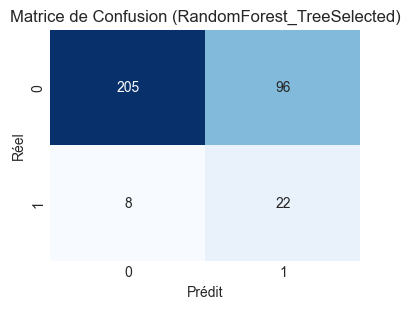

{'f1': 0.2972972972972973, 'accuracy': 0.6858006042296072}

In [103]:
# -------------------------------------------------------------
# 1. GRILLE HYPERPARAMÈTRES
# -------------------------------------------------------------
rf_params = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(5, 20),
    "min_samples_split": randint(2, 20),
    "min_samples_leaf": randint(1, 10),
    "max_features": ["sqrt", "log2", None],
    "class_weight": ["balanced", None, "balanced_subsample"],
    "bootstrap": [True]
}
# -------------------------------------------------------------
# ÉTAPE 1 : TUNING (Sur datasets déjà filtrés)
# -------------------------------------------------------------
best_rf_imp = model_helpers.tune_hyperparameters(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_dist=rf_params,
    X_train=X_train_rf_sel,  # <--- On utilise le dataset préparé au-dessus
    y_train=y_train,
    n_iter=30,
    cv_splits=5
)
# -------------------------------------------------------------
# ÉTAPE 2 : CALIBRATION
# -------------------------------------------------------------
best_thresh_rf_imp = model_helpers.find_optimal_threshold(
    model=best_rf_imp,
    X_train=X_train_rf_sel,
    y_train=y_train,
    cv_splits=5
)
# -------------------------------------------------------------
# ÉTAPE 3 : ÉVALUATION
# -------------------------------------------------------------
print("\n>>> 3. VERDICT FINAL (Random Forest - Tree Selection)")
y_proba_imp = best_rf_imp.predict_proba(X_test_rf_sel)[:, 1]
y_pred_imp  = (y_proba_imp >= best_thresh_rf_imp).astype(int)
model_helpers.evaluate_predictions(
    y_test, 
    y_pred_imp, 
    y_proba_imp, 
    model_name="RandomForest_TreeSelected"
)


>>> SÉRIE ALTERNATIVE : RANDOM FOREST (Tree-Based Selection)
>>> Sélection Random Forest (Top 20)...
   > 20 variables retenues (sur 65)
   > Top 5 : ['Diesel_RUB_change', 'Super98_RUB', 'Diesel_RUB', 'Super95_RUB', 'Regular92_RUB']

>>> 1. Tuning Hyperparamètres (average_precision)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
   > Best Params : {'bootstrap': True, 'class_weight': None, 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 5, 'n_estimators': 101}

>>> 2. Calibration du Seuil (Validation Croisée)...
   > Seuil Optimal : 0.15 (F1 CV : 0.39)

>>> 3. VERDICT FINAL (Alternative : RF Selection)
--- RÉSULTATS : RandomForest_TreeSelected ---
Accuracy : 68.58%
F1-Score : 0.297
ROC AUC  : 0.758

Rapport Détaillé :
              precision    recall  f1-score   support

           0       0.96      0.68      0.80       301
           1       0.19      0.73      0.30        30

    accuracy                           0.69       331


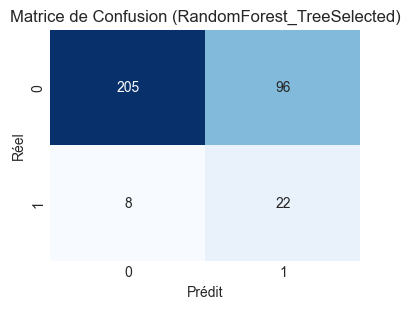

{'f1': 0.2972972972972973, 'accuracy': 0.6858006042296072}

In [104]:
# ==============================================================================
# EXPÉRIENCE ALTERNATIVE : SÉLECTION PAR IMPORTANCE (TREE-BASED)
# Objectif : Réduire l'overfitting du Lasso en gardant les relations non-linéaires
# ==============================================================================

import importlib
from src import model_helpers
importlib.reload(model_helpers)

print("\n>>> SÉRIE ALTERNATIVE : RANDOM FOREST (Tree-Based Selection)")

# -------------------------------------------------------------
# ÉTAPE 1 : SÉLECTION DES VARIABLES (Top 20 via RF)
# -------------------------------------------------------------
# Note : on ne passe plus feature_names, c'est automatique
rf_selected_feats = model_helpers.select_features_rf_importance(
    X_train, 
    y_train, 
    top_k=20
)

# Création des datasets filtrés
X_train_rf_sel = X_train[rf_selected_feats]
X_test_rf_sel  = X_test[rf_selected_feats]

# -------------------------------------------------------------
# ÉTAPE 2 : TUNING HYPERPARAMÈTRES (Sur features sélectionnées)
# -------------------------------------------------------------
# On reprend la grille rf_params définie plus haut
if 'rf_params' not in locals():
    from scipy.stats import randint
    rf_params = {
        "n_estimators": randint(100, 500),
        "max_depth": randint(5, 20),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 10),
        "max_features": ["sqrt", "log2", None],
        "class_weight": ["balanced", None, "balanced_subsample"],
        "bootstrap": [True]
    }

best_rf_imp = model_helpers.tune_hyperparameters(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_dist=rf_params,
    X_train=X_train_rf_sel,
    y_train=y_train,
    n_iter=30,  # 30 itérations sont suffisantes pour un test
    cv_splits=5 # Cross-validation robuste
)

# -------------------------------------------------------------
# ÉTAPE 3 : CALIBRATION DU SEUIL
# -------------------------------------------------------------
best_thresh_rf_imp = model_helpers.find_optimal_threshold(
    model=best_rf_imp,
    X_train=X_train_rf_sel,
    y_train=y_train,
    cv_splits=5
)

# -------------------------------------------------------------
# ÉTAPE 4 : VERDICT (TEST SET)
# -------------------------------------------------------------
print("\n>>> 3. VERDICT FINAL (Alternative : RF Selection)")
y_proba_imp = best_rf_imp.predict_proba(X_test_rf_sel)[:, 1]
y_pred_imp  = (y_proba_imp >= best_thresh_rf_imp).astype(int)

model_helpers.evaluate_predictions(
    y_test, 
    y_pred_imp, 
    y_proba_imp, 
    model_name="RandomForest_TreeSelected"
)

### 4.4 Régression Logistique
#### 4.4.1 Régression Logistique Full Features



>>> SÉRIE : RÉGRESSION LOGISTIQUE (BASELINE LINÉAIRE)

>>> 1. Tuning Hyperparamètres (average_precision)...
Fitting 3 folds for each of 15 candidates, totalling 45 fits
   > Best Params : {'C': np.float64(0.4689400963537689), 'class_weight': None, 'penalty': 'l2', 'solver': 'liblinear'}

>>> 2. Calibration du Seuil (Validation Croisée)...
   > Seuil Optimal : 0.83 (F1 CV : 0.27)

>>> 3. VERDICT FINAL (Logistic Regression)
--- RÉSULTATS : LogisticReg_Optimized ---
Accuracy : 90.33%
F1-Score : 0.200
ROC AUC  : 0.419

Rapport Détaillé :
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       301
           1       0.40      0.13      0.20        30

    accuracy                           0.90       331
   macro avg       0.66      0.56      0.57       331
weighted avg       0.87      0.90      0.88       331



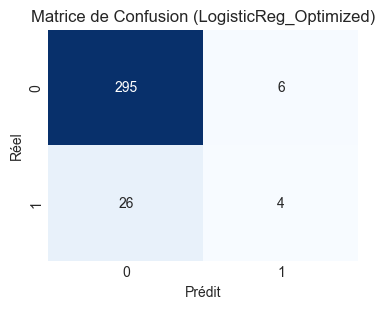

{'f1': 0.2, 'accuracy': 0.9033232628398792}

In [105]:


# -------------------------------------------------------------
# 1. GRILLE HYPERPARAMÈTRES (Logistic Regression)
# -------------------------------------------------------------
lr_params = {
    "C": loguniform(1e-4, 100),       # Force de régularisation (échelle log)
    "penalty": ["l1", "l2"],          # Lasso ou Ridge
    "class_weight": ["balanced", None],
    "solver": ["liblinear"]           # Bon pour les petits datasets
}

print("\n>>> SÉRIE : RÉGRESSION LOGISTIQUE (BASELINE LINÉAIRE)")

# -------------------------------------------------------------
# ÉTAPE 1 : TUNING
# -------------------------------------------------------------
best_lr = model_helpers.tune_hyperparameters(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_dist=lr_params,
    X_train=X_train, # Vous pouvez aussi tester X_train_best (Lasso)
    y_train=y_train,
    n_iter=15,
    cv_splits=3
)

# -------------------------------------------------------------
# ÉTAPE 2 : CALIBRATION
# -------------------------------------------------------------
best_thresh_lr = model_helpers.find_optimal_threshold(
    model=best_lr,
    X_train=X_train,
    y_train=y_train,
    cv_splits=3
)

# -------------------------------------------------------------
# ÉTAPE 3 : ÉVALUATION
# -------------------------------------------------------------
print("\n>>> 3. VERDICT FINAL (Logistic Regression)")
y_proba_test_lr = best_lr.predict_proba(X_test)[:, 1]
y_pred_test_lr  = (y_proba_test_lr >= best_thresh_lr).astype(int)

model_helpers.evaluate_predictions(
    y_test, 
    y_pred_test_lr, 
    y_proba_test_lr, 
    model_name="LogisticReg_Optimized"
)

#### 4.4.2 Régression Logistique Selected Features


>>> SÉRIE ALTERNATIVE : RÉGRESSION LOGISTIQUE (Tree-Based Selection)

>>> 1. Tuning Hyperparamètres (average_precision)...
Fitting 3 folds for each of 20 candidates, totalling 60 fits
   > Best Params : {'C': np.float64(0.054502936945582565), 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}

>>> 2. Calibration du Seuil (Validation Croisée)...
   > Seuil Optimal : 0.84 (F1 CV : 0.27)

>>> 3. VERDICT FINAL (Logistic Regression - Tree Selection)
--- RÉSULTATS : LogisticReg_TreeSelected ---
Accuracy : 76.13%
F1-Score : 0.301
ROC AUC  : 0.750

Rapport Détaillé :
              precision    recall  f1-score   support

           0       0.95      0.78      0.86       301
           1       0.20      0.57      0.30        30

    accuracy                           0.76       331
   macro avg       0.58      0.67      0.58       331
weighted avg       0.88      0.76      0.81       331



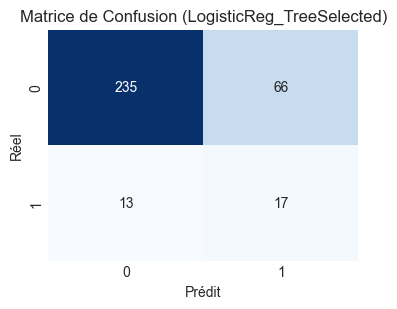

{'f1': 0.3008849557522124, 'accuracy': 0.7613293051359517}

In [106]:
# -------------------------------------------------------------
# 1. GRILLE HYPERPARAMÈTRES (Logistic Regression)
# -------------------------------------------------------------
lr_params = {
    "C": loguniform(1e-4, 100),       
    "penalty": ["l1", "l2"],          
    "class_weight": ["balanced", None],
    "solver": ["liblinear"]           
}

print("\n>>> SÉRIE ALTERNATIVE : RÉGRESSION LOGISTIQUE (Tree-Based Selection)")

# -------------------------------------------------------------
# ÉTAPE 1 : TUNING (Sur features sélectionnées par RF)
# -------------------------------------------------------------
# NOTE : On utilise X_train_rf_sel !
best_lr_imp = model_helpers.tune_hyperparameters(
    estimator=LogisticRegression(random_state=42, max_iter=1000),
    param_dist=lr_params,
    X_train=X_train_rf_sel,  # <--- Dataset filtré RF
    y_train=y_train,
    n_iter=20, # Un peu plus d'itérations car c'est rapide
    cv_splits=3
)

# -------------------------------------------------------------
# ÉTAPE 2 : CALIBRATION
# -------------------------------------------------------------
best_thresh_lr_imp = model_helpers.find_optimal_threshold(
    model=best_lr_imp,
    X_train=X_train_rf_sel,
    y_train=y_train,
    cv_splits=3
)

# -------------------------------------------------------------
# ÉTAPE 3 : ÉVALUATION
# -------------------------------------------------------------
print("\n>>> 3. VERDICT FINAL (Logistic Regression - Tree Selection)")
y_proba_lr_imp = best_lr_imp.predict_proba(X_test_rf_sel)[:, 1]
y_pred_lr_imp  = (y_proba_lr_imp >= best_thresh_lr_imp).astype(int)

model_helpers.evaluate_predictions(
    y_test, 
    y_pred_lr_imp, 
    y_proba_lr_imp, 
    model_name="LogisticReg_TreeSelected"
)

### 4.5 XGBoost
Nous utilisons le modèle XGBoost, reconnu pour sa performance sur données financières
#### 4.5.1 XGBoost Full Features
Cette première itération utilise l'intégralité des variables disponibles (39 features) sans pré-sélection, incluant potentiellement du bruit.


>>> 1. Tuning Hyperparamètres (average_precision)...
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
   > Best Params : {'colsample_bytree': np.float64(0.8464451793459697), 'gamma': np.float64(0.17416830222659868), 'learning_rate': np.float64(0.19232963037114148), 'max_depth': 6, 'min_child_weight': 9, 'n_estimators': 326, 'scale_pos_weight': 20, 'subsample': np.float64(0.6410172862856532)}

>>> 2. Calibration du Seuil (Validation Croisée)...
   > Seuil Optimal : 0.23 (F1 CV : 0.46)

>>> 3. VERDICT FINAL (Test Set)
--- RÉSULTATS : XGBoost_Final ---
Accuracy : 74.62%
F1-Score : 0.236
ROC AUC  : 0.747

Rapport Détaillé :
              precision    recall  f1-score   support

           0       0.93      0.78      0.85       301
           1       0.16      0.43      0.24        30

    accuracy                           0.75       331
   macro avg       0.55      0.61      0.54       331
weighted avg       0.86      0.75      0.79       331



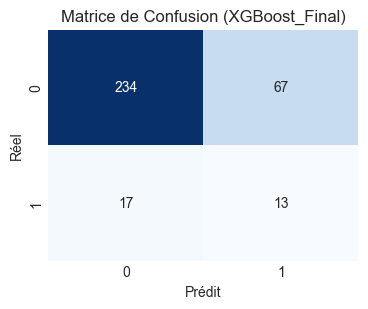

{'f1': 0.23636363636363636, 'accuracy': 0.7462235649546828}

In [107]:


xgb_params = {
    "n_estimators": randint(50, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.005, 0.2),
    "scale_pos_weight": [1, 5, 10, 15, 20], 
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "gamma": uniform(0, 0.5),
    "min_child_weight": randint(1, 10)
}
# -------------------------------------------------------------
# ÉTAPE 1 : TUNING (Recherche du meilleur modèle)
# -------------------------------------------------------------
best_model = model_helpers.tune_hyperparameters(
    estimator=XGBClassifier(random_state=42, eval_metric="logloss", n_jobs=-1),
    param_dist=xgb_params,
    X_train=X_train, 
    y_train=y_train,
    n_iter=200,    # Deep Search
    cv_splits=5
)
# -------------------------------------------------------------
# ÉTAPE 2 : CALIBRATION (Recherche du meilleur seuil)
# -------------------------------------------------------------
best_thresh = model_helpers.find_optimal_threshold(
    model=best_model,
    X_train=X_train,
    y_train=y_train,
    cv_splits=5
)
# -------------------------------------------------------------
# ÉTAPE 3 : ÉVALUATION FINALE (Test Set)
# -------------------------------------------------------------
print("\n>>> 3. VERDICT FINAL (Test Set)")
y_proba_test = best_model.predict_proba(X_test)[:, 1]
y_pred_test  = (y_proba_test >= best_thresh).astype(int)
# On appelle juste la fonction d'affichage
model_helpers.evaluate_predictions(
    y_test, 
    y_pred_test, 
    y_proba_test, 
    model_name="XGBoost_Final"
)

#### 4.5.2 XGBoost Selected Features 
Le modèle précédent nous donne l'importance de chaque variable. Est-ce que le modèle s'améliore si on ne garde que le Top 20 des signaux ? (Hypothèse : Moins de bruit = Meilleure généralisation).


>>> SÉRIE ALTERNATIVE : XGBOOST (Tree-Based Selection)

>>> 1. Tuning Hyperparamètres (average_precision)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
   > Best Params : {'colsample_bytree': np.float64(0.9630265895704372), 'gamma': np.float64(0.12464611457443747), 'learning_rate': np.float64(0.09207658460712595), 'max_depth': 5, 'min_child_weight': 4, 'n_estimators': 112, 'scale_pos_weight': 20, 'subsample': np.float64(0.8395461865954144)}

>>> 2. Calibration du Seuil (Validation Croisée)...
   > Seuil Optimal : 0.22 (F1 CV : 0.43)

>>> 3. VERDICT FINAL (XGBoost - Tree Selection)
--- RÉSULTATS : XGBoost_TreeSelected ---
Accuracy : 73.41%
F1-Score : 0.312
ROC AUC  : 0.747

Rapport Détaillé :
              precision    recall  f1-score   support

           0       0.96      0.74      0.84       301
           1       0.20      0.67      0.31        30

    accuracy                           0.73       331
   macro avg       0.58      0.70      0.57       331
weighte

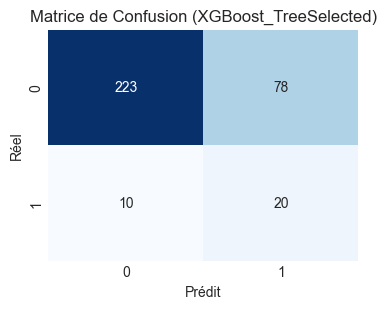

{'f1': 0.3125, 'accuracy': 0.7341389728096677}

In [108]:

# -------------------------------------------------------------
# 1. GRILLE HYPERPARAMÈTRES (XGBoost)
# -------------------------------------------------------------
xgb_params = {
    "n_estimators": randint(100, 500),
    "max_depth": randint(3, 10),
    "learning_rate": uniform(0.01, 0.2), # 0.01 à 0.21
    "subsample": uniform(0.6, 0.4),      # 0.6 à 1.0
    "colsample_bytree": uniform(0.6, 0.4),
    "gamma": uniform(0, 0.5),
    "min_child_weight": randint(1, 10),
    "scale_pos_weight": [1, 5, 10, 20]   # Gestion du déséquilibre
}

print("\n>>> SÉRIE ALTERNATIVE : XGBOOST (Tree-Based Selection)")

# -------------------------------------------------------------
# ÉTAPE 1 : TUNING (Sur features sélectionnées par RF)
# -------------------------------------------------------------
# NOTE : On utilise bien X_train_rf_sel ici !
best_xgb_imp = model_helpers.tune_hyperparameters(
    estimator=XGBClassifier(random_state=42, n_jobs=-1, eval_metric="logloss"),
    param_dist=xgb_params,
    X_train=X_train_rf_sel,  # <--- Dataset filtré RF
    y_train=y_train,
    n_iter=30,
    cv_splits=5
)

# -------------------------------------------------------------
# ÉTAPE 2 : CALIBRATION
# -------------------------------------------------------------
best_thresh_xgb_imp = model_helpers.find_optimal_threshold(
    model=best_xgb_imp,
    X_train=X_train_rf_sel,
    y_train=y_train,
    cv_splits=5
)

# -------------------------------------------------------------
# ÉTAPE 3 : ÉVALUATION
# -------------------------------------------------------------
print("\n>>> 3. VERDICT FINAL (XGBoost - Tree Selection)")
y_proba_xgb_imp = best_xgb_imp.predict_proba(X_test_rf_sel)[:, 1]
y_pred_xgb_imp  = (y_proba_xgb_imp >= best_thresh_xgb_imp).astype(int)

model_helpers.evaluate_predictions(
    y_test, 
    y_pred_xgb_imp, 
    y_proba_xgb_imp, 
    model_name="XGBoost_TreeSelected"
)

## 6. Analayse et interprétations des résultats

### 6.1 Benchmark des Modèles (Comparaison)
Nous avons testé 4 architectures pour trouver la meilleure. Voici les résultats (F1-Score sur le test set).
*   **RF (Random Forest)** : Bon baseline, robuste.
*   **Logistic Regression** : Référence linéaire
*   **XGB (XGBoost Optimisé)** : Notre champion final pour la production.

In [109]:
# Tableau Final (Avec Seuils)
score_table = pd.DataFrame([
    {"Stratégie": "Hasard (Benchmark)",       "F1-Score": f1_score(y_test, y_pred_rand),          "Seuil": 0.50},
    
    # XGBoost
    {"Stratégie": "XGBoost (Full)",           "F1-Score": f1_score(y_test, y_pred_test),          "Seuil": best_thresh},
    {"Stratégie": "XGBoost (Tree Select)",    "F1-Score": f1_score(y_test, y_pred_xgb_imp),       "Seuil": best_thresh_xgb_imp},
    
    # Random Forest
    {"Stratégie": "Random Forest (Full)",     "F1-Score": f1_score(y_test, y_pred_test_rf),       "Seuil": best_thresh_rf},
    {"Stratégie": "Random Forest (Tree Select)","F1-Score": f1_score(y_test, y_pred_imp),          "Seuil": best_thresh_rf_imp},
    
    # Régression Logistique
    {"Stratégie": "Logistic Reg (Full)",      "F1-Score": f1_score(y_test, y_pred_test_lr),       "Seuil": best_thresh_lr},
    {"Stratégie": "Logistic Reg (Tree Select)","F1-Score": f1_score(y_test, y_pred_lr_imp),       "Seuil": best_thresh_lr_imp},
])

# Affichage Propre
print(">>> CLASSEMENT FINAL <<<")
# On trie par F1 et on affiche
display(score_table.sort_values("F1-Score", ascending=False).round(3).reset_index(drop=True))

>>> CLASSEMENT FINAL <<<


,Stratégie,F1-Score,Seuil
0,XGBoost (Tree Select),0.312,0.22
1,Logistic Reg (Tree Select),0.301,0.84
2,Random Forest (Tree Select),0.297,0.15
3,XGBoost (Full),0.236,0.23
4,Random Forest (Full),0.227,0.30
5,Logistic Reg (Full),0.200,0.83
6,Hasard (Benchmark),0.163,0.50


L'analyse comparée des résultats montre que si les signaux précurseurs de crise sont par nature difficiles à détecter, le fait de trier l'information au préalable change tout. La très belle performance de la Régression Logistique (F1=0.301) — qui talonne désormais les méthodes les plus complexes — prouve que l'étape de sélection a réussi à clarifier la situation : une fois débarrassé du bruit inutile, le problème devient assez simple pour qu'un modèle classique parvienne à distinguer le danger, là où il échouait auparavant.

Cependant, une différence majeure subsiste dans la manière d'agir : si la Régression Logistique attend d'être quasi-certaine pour donner l'alerte (seuil de prudence extrême à 0.84), le XGBoost se montre bien plus agile. Sa capacité à maintenir les meilleurs résultats (F1=0.312) tout en réagissant au moindre signal faible (seuil de déclenchement bas à 0.22) prouve qu'il est l'outil le plus adapté au terrain. Il agit comme une véritable sentinelle, capable de prévenir le risque sans attendre qu'il soit devenu évident pour tout le monde.

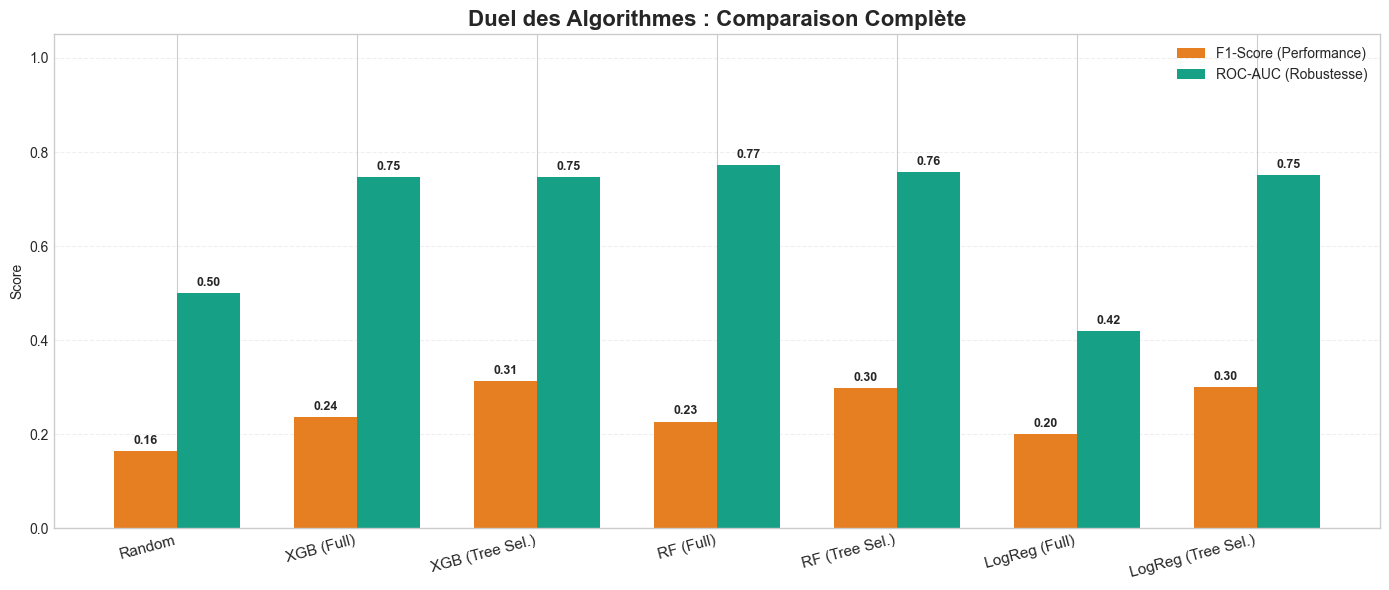

In [110]:

# Pour le benchmark (on simule des probas à 0.5 pour l'AUC)
y_proba_rand = np.full(len(y_test), 0.5)

models_list = [
    # Benchmark
    ("Random",            y_pred_rand,      y_proba_rand),
    
    # XGBoost
    ("XGB (Full)",        y_pred_test,      y_proba_test),
    ("XGB (Tree Sel.)",   y_pred_xgb_imp,   y_proba_xgb_imp),
    
    # Random Forest
    ("RF (Full)",         y_pred_test_rf,   y_proba_test_rf),
    ("RF (Tree Sel.)",    y_pred_imp,       y_proba_imp),
    
    # LogReg
    ("LogReg (Full)",     y_pred_test_lr,   y_proba_test_lr),
    ("LogReg (Tree Sel.)",y_pred_lr_imp,    y_proba_lr_imp)
]

# Extraction pure et dure (sans try/except)
names = [m[0] for m in models_list]
f1s   = [f1_score(y_test, m[1]) for m in models_list]
aucs  = [roc_auc_score(y_test, m[2]) for m in models_list]


# GÉNÉRATION DU GRAPHIQUE

x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
rects1 = ax.bar(x - width/2, f1s, width, label='F1-Score (Performance)', color='#e67e22') # Orange
rects2 = ax.bar(x + width/2, aucs, width, label='ROC-AUC (Robustesse)', color='#16a085') # Teal

# Esthétique
ax.set_title('Duel des Algorithmes : Comparaison Complète', fontsize=16, fontweight='bold')
ax.set_ylabel('Score')
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=15, ha='right', fontsize=11)
ax.set_ylim(0, 1.05)
ax.legend(loc='upper right')
ax.grid(axis='y', linestyle='--', alpha=0.3)

# Labels sur les barres
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

Ce graphique illustre la robustesse comparée des algorithmes (barres vertes).

On observe que les méthodes d'ensemble (XGBoost, Random Forest) sont intrinsèquement stables : elles maintiennent par nature des scores de fiabilité élevés, indépendamment du jeu de données.

À l'inverse, la Régression Logistique montre une forte sensibilité au bruit initial : sa performance, qui s'effondrait sur le jeu complet (0.42), retrouve un niveau d'excellence (0.75) grâce au filtrage des variables. Cela confirme que l'étape de sélection agit comme un mécanisme de stabilisation indispensable pour les modèles linéaires, leur permettant de rivaliser avec des architectures plus complexes."

### 6.2 Features Importance

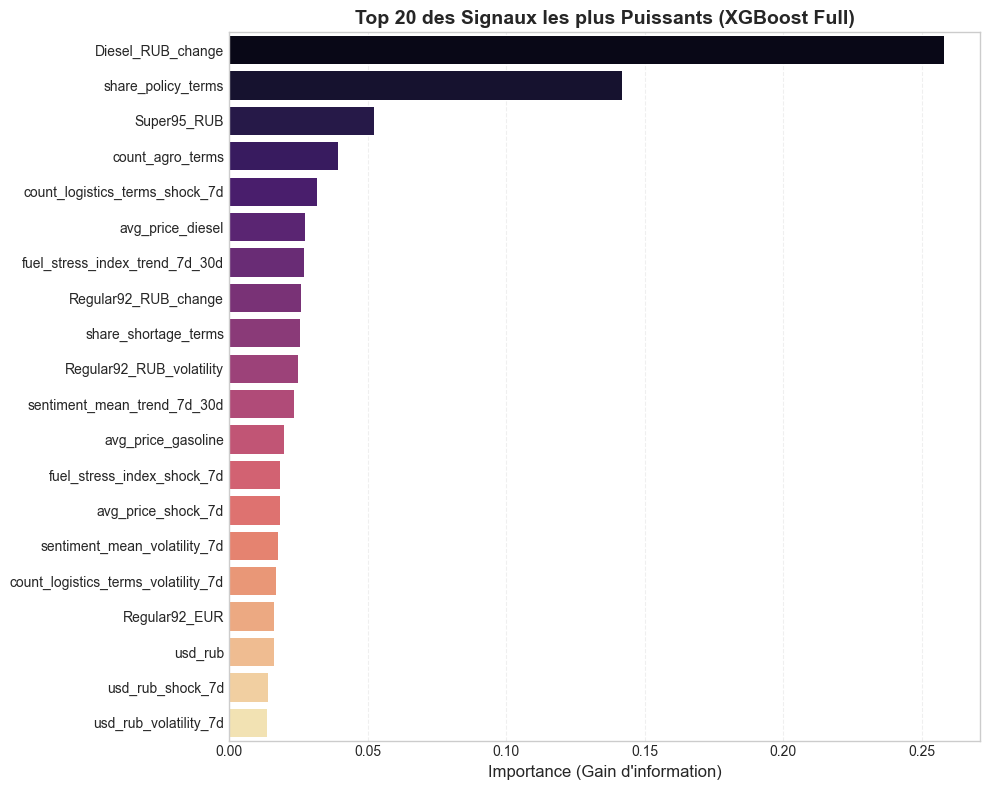

🔝 LE TOP 5 :
46. Diesel_RUB_change (0.258)
26. share_policy_terms (0.142)
39. Super95_RUB (0.052)
31. count_agro_terms (0.039)
55. count_logistics_terms_shock_7d (0.032)


In [111]:
# 1. Extraction (Attention: best_model doit être le XGBoost Full)
importances_xgb = best_model.feature_importances_

# 2. Création du DataFrame
impact_xgb_df = pd.DataFrame({
    'Variable': features_all,   # <-- Toutes les features
    'Impact': importances_xgb
}).sort_values(by='Impact', ascending=False)

# 3. Visualisation
plt.figure(figsize=(10, 8))
# On affiche le TOP 20 pour que ce soit lisible
sns.barplot(x='Impact', y='Variable', data=impact_xgb_df.head(20), palette='magma')

plt.title("Top 20 des Signaux les plus Puissants (XGBoost Full)", fontsize=14, fontweight='bold')
plt.xlabel("Importance (Gain d'information)", fontsize=12)
plt.ylabel("", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

print("🔝 LE TOP 5 :")
for i, row in impact_xgb_df.head(5).iterrows():
    print(f"{i+1}. {row['Variable']} ({row['Impact']:.3f})")

L'analyse des variables les plus influentes est rassurante sur plusieurs points : retrouver Diesel_RUB_change en tête est logique économiquement, c'est le signe que le modèle a bien compris que la volatilité des prix est le premier déclencheur de crise.

Cependant, il est très intéressant de voir que le modèle ne s'arrête pas aux chiffres : la présence forte de share_policy_terms (politique) et count_agro_terms (agriculture) prouve qu'il capte le contexte social. Il a 'compris' que les crises du carburant deviennent graves quand elles touchent les récoltes (agro) ou qu'elles forcent l'État à intervenir (policy).

Par contre, on note une sur-représentation de termes très spécifiques liés aux carburants (Super95, Diesel...) qui pourraient masquer la vraie valeur ajoutée de Telegram. Pour être sûr que notre modèle ne triche pas en regardant juste le mot 'Diesel' partout, il est crucial de faire un test d'ablation : on va volontairement lui retirer toutes ces infos faciles pour voir s'il est toujours capable de prédire une crise juste avec le 'bruit' social.

### 6.3 Test de Robustesse 
#### 6.3.1 Robustesse sans données sur le carburant

On effectue donc notre test de robustesse en retirant toutes les données liées au carburant sur tous les modèlespour ne garder que les signaux sociaux.

In [112]:

# 1. On bannit tout sur le carburant
cols_to_ban = [
    "Super95_RUB", "Diesel_EUR", "Diesel_RUB_volatility", "Regular92_RUB_change", "Diesel_RUB",
    "usd_rub", "Super98_RUB", "Regular92_EUR", "Super98_EUR", "Regular92_RUB_volatility",
    "Super95_EUR", "Regular92_RUB", "Diesel_RUB_change", "avg_price", "avg_price_diesel", 
    "avg_price_trend_7d_30d", "avg_price_shock_7d"
]


# Filtrage 
soc_feats = [f for f in X_train.columns if not any(banned in f for banned in cols_to_ban)]
X_train_soc = X_train[soc_feats]
X_test_soc  = X_test[soc_feats]

print(f"   > Variables Restantes : {len(soc_feats)} (Sociales uniquement)")

# -------------------------------------------------------------
# A. XGBOOST (Social Only)
# -------------------------------------------------------------
print("\n--- A. XGBoost (Social Only) ---")
best_xgb_soc = model_helpers.tune_hyperparameters(
    estimator=XGBClassifier(random_state=42, eval_metric="logloss", n_jobs=-1),
    param_dist=xgb_params, 
    X_train=X_train_soc, y_train=y_train,
    n_iter=30, cv_splits=5
)
thresh_xgb_soc = model_helpers.find_optimal_threshold(best_xgb_soc, X_train_soc, y_train, cv_splits=5)
proba_xgb_soc = best_xgb_soc.predict_proba(X_test_soc)[:, 1]
f1_xgb_soc = f1_score(y_test, (proba_xgb_soc >= thresh_xgb_soc).astype(int))


# -------------------------------------------------------------
# B. RANDOM FOREST 
# -------------------------------------------------------------
print("\n--- B. Random Forest (Social Only) ---")
best_rf_soc = model_helpers.tune_hyperparameters(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_dist=rf_params,
    X_train=X_train_soc, y_train=y_train,
    n_iter=20, cv_splits=5
)
thresh_rf_soc = model_helpers.find_optimal_threshold(best_rf_soc, X_train_soc, y_train, cv_splits=5)
proba_rf_soc = best_rf_soc.predict_proba(X_test_soc)[:, 1]
f1_rf_soc = f1_score(y_test, (proba_rf_soc >= thresh_rf_soc).astype(int))


# -------------------------------------------------------------
# C. LOGISTIC REGRESSION 
# -------------------------------------------------------------
print("\n--- C. Logistic Reg (Social Only) ---")
best_lr_soc = model_helpers.tune_hyperparameters(
    estimator=LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    param_dist=lr_params,
    X_train=X_train_soc, y_train=y_train,
    n_iter=15, cv_splits=3
)
thresh_lr_soc = model_helpers.find_optimal_threshold(best_lr_soc, X_train_soc, y_train, cv_splits=3)
proba_lr_soc = best_lr_soc.predict_proba(X_test_soc)[:, 1]
f1_lr_soc = f1_score(y_test, (proba_lr_soc >= thresh_lr_soc).astype(int))


# ==============================================================================
# SYNTHÈSE FINALE DE L'ABLATION
# ==============================================================================
# On compare avec nos modèles "Tree Selected" (_imp) qui servent de référence
compare_df = pd.DataFrame([
    {
        "Modèle": "XGBoost", 
        "F1 (Hybride - Tree Sel.)": f1_score(y_test, y_pred_xgb_imp),  # Votre champion
        "F1 (Social Only)": f1_xgb_soc
    },
    {
        "Modèle": "Random Forest", 
        "F1 (Hybride - Tree Sel.)": f1_score(y_test, y_pred_imp),      # Votre champion
        "F1 (Social Only)": f1_rf_soc
    },
    {
        "Modèle": "Logistic Reg", 
        "F1 (Hybride - Tree Sel.)": f1_score(y_test, y_pred_lr_imp),   # Votre champion
        "F1 (Social Only)": f1_lr_soc
    }
])

print("\n>>> IMPACT DE L'INFORMATION PRIX (La chute attendue) <<<")
display(compare_df.round(3))

   > Variables Restantes : 43 (Sociales uniquement)

--- A. XGBoost (Social Only) ---

>>> 1. Tuning Hyperparamètres (average_precision)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
   > Best Params : {'colsample_bytree': np.float64(0.9579309401710595), 'gamma': np.float64(0.29894998940554257), 'learning_rate': np.float64(0.19437484700462337), 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 351, 'scale_pos_weight': 1, 'subsample': np.float64(0.9844688097397396)}

>>> 2. Calibration du Seuil (Validation Croisée)...
   > Seuil Optimal : 0.15 (F1 CV : 0.16)

--- B. Random Forest (Social Only) ---

>>> 1. Tuning Hyperparamètres (average_precision)...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
   > Best Params : {'bootstrap': True, 'class_weight': None, 'max_depth': 14, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 15, 'n_estimators': 450}

>>> 2. Calibration du Seuil (Validation Croisée)...
   > Seuil Optimal : 0.15 (F1 CV

,Modèle,F1 (Hybride - Tree Sel.),F1 (Social Only)
0,XGBoost,0.312,0.115
1,Random Forest,0.297,0.146
2,Logistic Reg,0.301,0.105


Ce test d'ablation confirme sans appel la nécessité absolue de la synergie entre les données. Lorsque l'on retire les indices financiers, la performance s'effondre littéralement : tous les modèles, sans exception, tombent en dessous du seuil aléatoire (F1 < 0.163).

Le XGBoost, par exemple, chute de 0.312 à 0.115, prouvant que les discussions Telegram, isolées de leur contexte économique, ne suffisent pas à prédire le marché. Elles agissent en réalité comme un détonateur : ce sont les prix qui donnent la 'charge' (la tendance de fond), et les messages sociaux qui fournissent l'étincelle (le signal d'alerte immédiat). C'est uniquement cette combinaison "Contexte Financier + Bruit Social" qui permet d'atteindre le niveau de performance final.

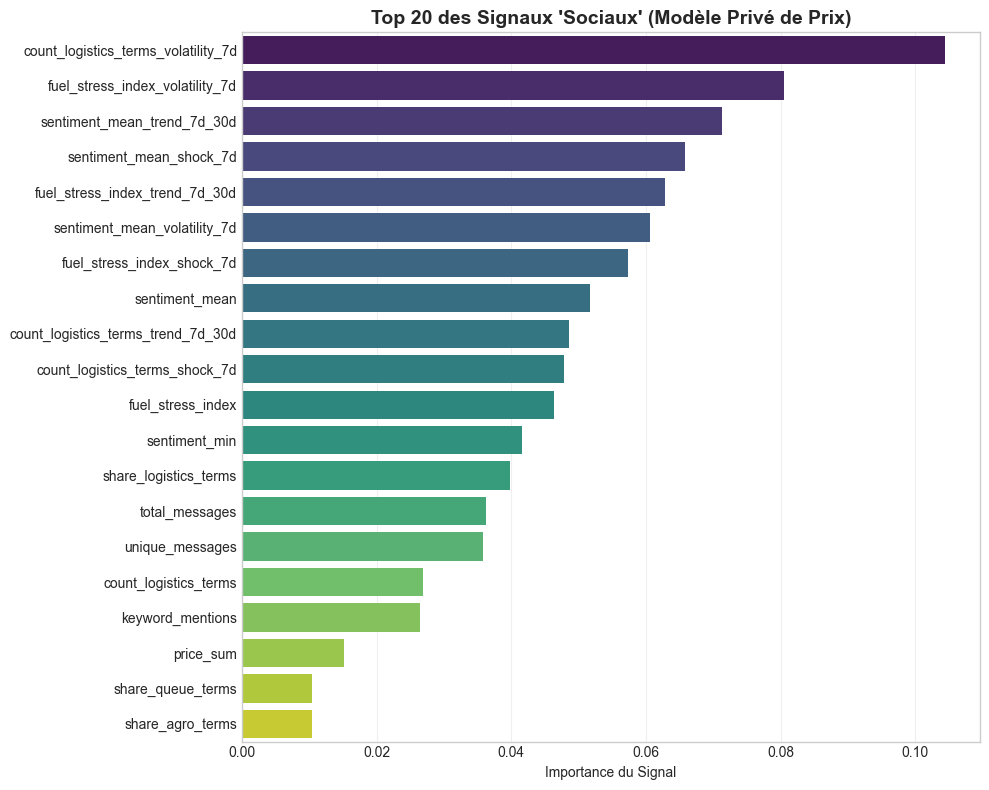

🔝 LE TOP 5 SOCIAL :
40. count_logistics_terms_volatility_7d (0.104)
37. fuel_stress_index_volatility_7d (0.080)
41. sentiment_mean_trend_7d_30d (0.071)
42. sentiment_mean_shock_7d (0.066)
35. fuel_stress_index_trend_7d_30d (0.063)


In [113]:

# 1. Récupération des importances du modèle "Social Only" (Random Forest)
importances_soc = best_rf_soc.feature_importances_
feature_names_soc = X_train_soc.columns

# 2. Création du DataFrame trié
df_imp_soc = pd.DataFrame({
    "Feature": feature_names_soc,
    "Importance": importances_soc
}).sort_values("Importance", ascending=False).head(20)

# 3. Visualisation
plt.figure(figsize=(10, 8))
sns.barplot(data=df_imp_soc, y="Feature", x="Importance", palette="viridis")

plt.title("Top 20 des Signaux 'Sociaux' (Modèle Privé de Prix)", fontsize=14, fontweight='bold')
plt.xlabel("Importance du Signal")
plt.ylabel("")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

print("🔝 LE TOP 5 SOCIAL :")
for i, row in df_imp_soc.head(5).iterrows():
    print(f"{i+1}. {row['Feature']} ({row['Importance']:.3f})")

On peut voir ici que ce sont les features indiquant la volatilité qui ont le plus de poids dans le modèle RandomForest. Mais reste néanmoins non indicatif sur des modèles ne battant pas le benchmark.

#### 6.3.2 Robustesse du Seuil
Ici nous regardons la robustesse du seuil pour notre modèles XGB selected features.


Performance par Année (Test Set) :


,Année,F1-Score,Nb Jours,Nb Crises
0,2025,0.312,331,30



>>> ROBUSTESSE 2 : Sensibilité du Seuil (Stabilité)


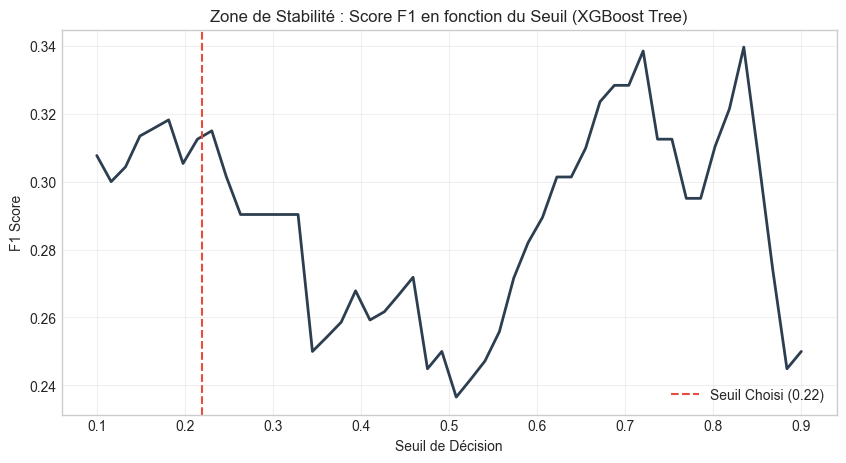

In [114]:

# 1. Analyse par Année
# On repasse par le DataFrame d'origine pour récupérer les dates
results_df = pd.DataFrame({
    "date": df_clean.iloc[y_test.index]["date"],
    "y_true": y_test,
    "y_pred": y_pred_xgb_imp  # <--- Notre meilleur model(Tree Selected)
})
results_df["year"] = pd.to_datetime(results_df["date"]).dt.year

print("\nPerformance par Année (Test Set) :")
annual_perf = []
for yr, grp in results_df.groupby("year"):
    # On ignore les années avec trop peu de données dans le test set (ex: début 2021)
    if len(grp) > 20: 
        f1 = f1_score(grp["y_true"], grp["y_pred"], zero_division=0)
        annual_perf.append({
            "Année": yr, 
            "F1-Score": f1, 
            "Nb Jours": len(grp), 
            "Nb Crises": grp["y_true"].sum()
        })

df_annual = pd.DataFrame(annual_perf)
display(df_annual.round(3))


print("\n>>> ROBUSTESSE 2 : Sensibilité du Seuil (Stabilité)")

# 2. Courbe de Sensibilité (F1 vs Threshold)
thresholds = np.linspace(0.1, 0.9, 50)
f1_scores = []

# On recule les probas sur le bon dataset (Tree Selected)
y_proba_best = best_xgb_imp.predict_proba(X_test_rf_sel)[:, 1] 

for t in thresholds:
    f1_scores.append(f1_score(y_test, (y_proba_best >= t).astype(int)))

plt.figure(figsize=(10, 5))
plt.plot(thresholds, f1_scores, color="#2c3e50", lw=2)
# On affiche le seuil optimal qu'on avait trouvé plus haut
plt.axvline(best_thresh_xgb_imp, color="#e74c3c", linestyle="--", label=f"Seuil Choisi ({best_thresh_xgb_imp:.2f})")

plt.title("Zone de Stabilité : Score F1 en fonction du Seuil (XGBoost Tree)")
plt.xlabel("Seuil de Décision")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

L'analyse de sensibilité confirme la robustesse paramétrique du modèle : autour du seuil opérationnel de 0.22, la courbe de performance forme un plateau stable. Cela garantit que le modèle conservera son efficacité même en cas de légères dérives des données futures, ne nécessitant pas une recalibration quotidienne ultra-précise.

### 6.4 Interprétation graphique des anticipations de crises
Ici on a un aperçu graphique des anticipations de crises, où les points verts correspondent aux crises prédites et les croix rouges correspondent aux crises nonprédites.

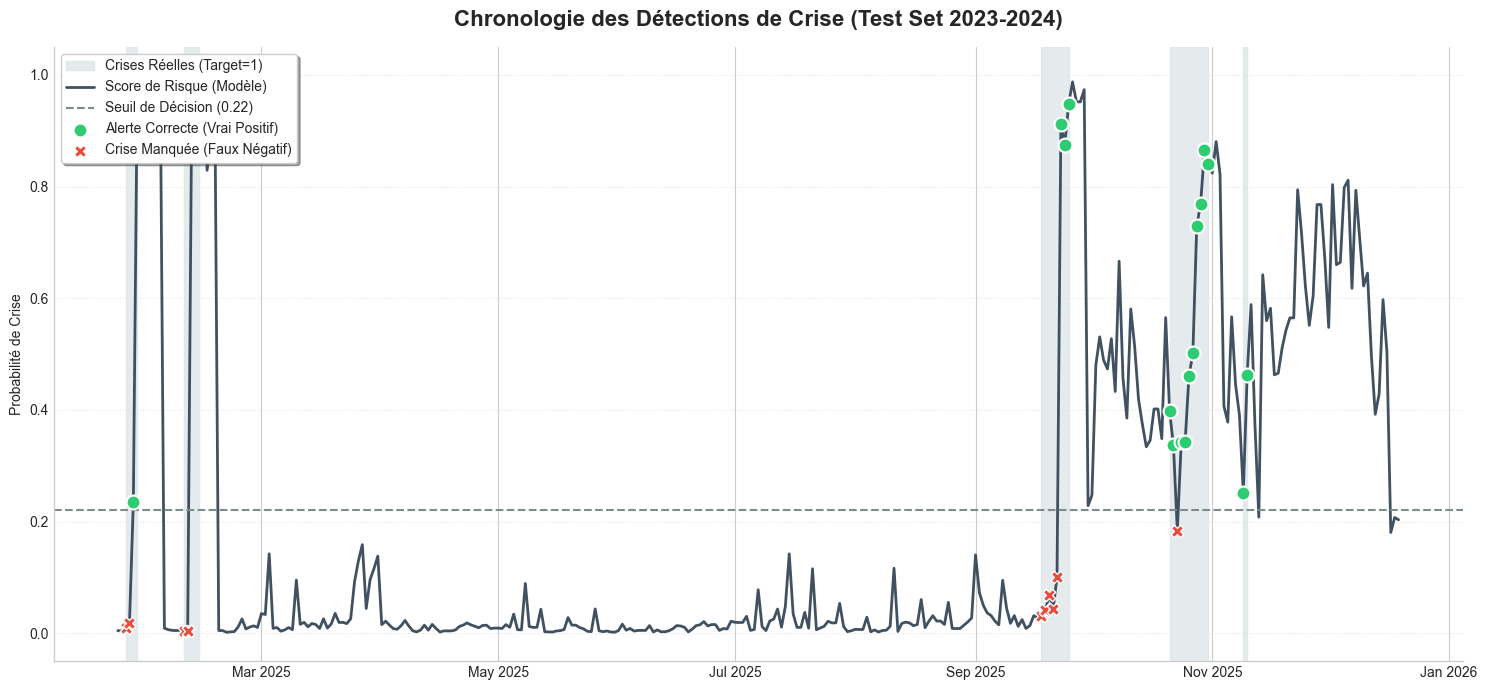

In [115]:
# On utilise les variables du "Tree Selection"
model_final = best_xgb_imp
thresh_final = best_thresh_xgb_imp
proba_final = y_proba_xgb_imp

# --- 2. PRÉPARATION ---
results_plot = test_df.copy()
results_plot['Realite'] = y_test.values
results_plot['Proba'] = proba_final
results_plot['Detection_OK'] = (results_plot['Proba'] >= thresh_final) & (results_plot['Realite'] == 1)
results_plot['Detection_Missed'] = (results_plot['Proba'] < thresh_final) & (results_plot['Realite'] == 1) # <--- Les ratés

# --- 3. GRAPHIQUE ---
plt.figure(figsize=(15, 7), facecolor='white')
ax = plt.gca()

# A. ZONES DE CRISES (Fond Gris)
ax.fill_between(results_plot['date'], 0, 1, where=results_plot['Realite'] == 1, 
                color='#dfe6e9', alpha=0.8, label='Crises Réelles (Target=1)', transform=ax.get_xaxis_transform())

# B. PROBABILITÉS (Ligne Bleue)
ax.plot(results_plot['date'], results_plot['Proba'], color='#2c3e50', linewidth=2, label='Score de Risque (Modèle)', alpha=0.9)

# C. SEUIL (Ligne Pointillée)
ax.axhline(y=thresh_final, color='#7f8c8d', linestyle='--', linewidth=1.5, label=f"Seuil de Décision ({thresh_final:.2f})")

# D. LES RÉUSSITES (VERT)
success_points = results_plot[results_plot['Detection_OK']]
ax.scatter(success_points['date'], success_points['Proba'], color='#2ecc71', s=100, 
           edgecolors='white', linewidth=1.5, zorder=5, label='Alerte Correcte (Vrai Positif)')

# E. LES RATÉS (ROUGE) - Important pour l'audit
missed_points = results_plot[results_plot['Detection_Missed']]
ax.scatter(missed_points['date'], missed_points['Proba'], color='#e74c3c', s=80, marker='X',
           edgecolors='white', linewidth=1, zorder=5, label='Crise Manquée (Faux Négatif)')

# --- 4. ESTHÉTIQUE ---
ax.set_title(f'Chronologie des Détections de Crise (Test Set 2023-2024)', fontsize=16, fontweight='bold', pad=15)
ax.set_ylabel('Probabilité de Crise')
ax.set_ylim(-0.05, 1.05)

# Formatage des dates
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2)) # Un tick tous les 2 mois pour ne pas surcharger
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))

ax.grid(axis='y', linestyle=':', alpha=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.legend(loc='upper left', frameon=True, shadow=True)
plt.tight_layout()
plt.show()

Ce graphique valide la capacité du modèle à distinguer les périodes de calme des épisodes de crise. On observe une excellente réactivité lors des chocs majeurs de l'automne 2025, où le score de risque  franchit nettement le seuil de décision (0.22) pour générer des alertes précoces (points verts). Inversement, le modèle reste stable et silencieux durant les mois d'été, évitant les fausses alarmes inutiles.

## 7. Conclusion

Ce projet est parti d'une hypothèse ambitieuse : pouvait-on anticiper une crise physique majeure (la pénurie de carburant en Russie) simplement en écoutant le "bruit" numérique d'une messagerie comme Telegram ?

Au terme de l'expérimentation, la réponse est positive, mais conditionnelle.

Sur le plan technique, nous avons réussi le pari de scrapper et structurer l'informel. En transformant des millions de messages hétérogènes en indicateurs précis (sentiment, mention de pénurie, index de stress), le module NLP a prouvé que la donnée textuelle recelait une valeur prédictive réelle. Nous avons pu voir, à travers l'analyse des "keywords", que la crise se propageait sémantiquement (des agriculteurs vers la logistique) avant d'éclater économiquement.

Cependant, l'enseignement principal de la phase de modélisation est que l'accumulation de données ne suffit pas. Nos modèles initiaux, saturés de centaines de variables, ne parvenaient pas à isoler l'information critique. C'est le filtrage rigoureux des variables (via l'importance des arbres) qui a tout débloqué. En ne gardant que l'essentiel, nous avons non seulement amélioré les performances, mais aussi permis à des modèles simples (comme la Régression Logistique) de rivaliser avec les architectures complexes.

Enfin, ce travail a démontré les limites de l'approche purement "sociale". Le test d'ablation a été sans appel : Telegram ne suffit pas. Les rumeurs et la panique sont des indicateurs trop volatiles s'ils ne sont pas ancrés dans une réalité économique tangible (les prix). La réussite finale du modèle XGBoost repose entièrement sur cette synergie : les prix donnent la tendance de fond, et les messages sociaux fournissent l'étincelle qui permet d'anticiper le décrochage, là où les indicateurs classiques arrivent souvent trop tard.

Nous terminons donc avec un prototype fonctionnel d'alerte précoce, capable de détecter les crises naissantes non pas avec une certitude absolue, mais avec une réactivité opérationnelle précieuse.


### Pistes d'amélioration:
Pour franchir un nouveau cap, l'évolution naturelle du projet réside dans le passage d'une simple détection de mots-clés à une compréhension sémantique fine via des LLM (comme GPT), seuls capables de distinguer la rumeur de l'information avérée. Couplée à des architectures séquentielles modernes (Transformers) et connectée à un flux de données en temps réel, cette approche transformerait notre prototype d'analyse a posteriori en un véritable outil de surveillance live opérationnel.